# Machine learning-accelerated chemistry of protoplanetary disks
### Supplementary materials
##### Grigorii V. Smirnov-Pinchukov, Tamara Molyarova, Dmitry A. Semenov, Vitaly V. Akimkin, Sierk van Terwisga, Riccardo Francheschi, and Thomas Henning

> *Aims*. With large amounts of molecular emission data from (sub)millimeter observatories, it is paramount to have a
fast method to calculate the chemical composition of gas in protoplanetary disks.
> *Methods*. We use thermochemical modeling code to generate a diverse population of protoplanetary disk models. We train the K Near-
est Neighbors regressor to instantly predict the chemistry of other disk models.
> *Results*. We show that due to correlations between the physical parameters in the protoplanetary disk, it is enough to use just a few
most important parameters to describe disk chemistry precisely. We discuss the uncertainties and limitations of this method.
> *Conclusions*. The method we utilize can be used for Bayesian fitting of the line emission data. We present a pipeline to use other
existing chemical disk modeling tools with the same approach.

We provide this Jupyter notebook as a way to reproduce the results from our paper. We encourage colleagues to reproduce our results and use this notebook
as a template for their pipelines to predict disk (or other environment) chemistry based on various physico-chemical models.

<a href="mailto:smirngreg@gmail.com">E-mail us! smirngreg@gmail.com</a>
### Installing

We suggest using the latest release of Anaconda to run this notebook. Anaconda is a conda-based Python distribution with stable versions of libraries.
It can be installed without root privileges, and is available for Windows, Linux, and Mac OS. If you don't have conda yet, install
[Miniconda](https://docs.conda.io/en/latest/miniconda.html) (just conda package manager). After installation, execute `conda init <mysh>`, replacing
`<mysh>` with the shell interpreter (zsh, bash) you prefer. This will add conda initialization to your login procedure.

Once conda is installed, you should have `(base)` at the beginning of your prompt line (bash) or somewhere else (modern zsh themes). Then, create a
separate environment (for example, let's call it mlchem):

```
conda create -y -n mlchem anaconda
conda activate mlchem
```

Additionally, you can install an optional package chemical-names, which converts strings like `HCO+` and `H2O` to `HCO^+` and `H_2O` respectively.

```
pip install git+https://gitlab.com/SmirnGreg/chemical_names.git
```

Now, you are ready to start. Run the Jupyter notebook in your prefered way: from PyCharm Professional, Jupyter Lab `jupyter lab diskchef_chemistry.ipynb`, or old way `jupyter notebook diskchef_chemistry.ipynb`


#### Importing libraries

In [1]:
import datetime
import pathlib
import pickle
from typing import List
import math
from itertools import cycle

import matplotlib.colors
import matplotlib.patheffects as PathEffects
import numpy as np
import pandas as pd
import sklearn.neural_network
import sqlalchemy
from matplotlib import colors, cm, patches
from matplotlib import pyplot as plt
from sklearn import neighbors as sn
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer

try:
    # !pip install git+https://gitlab.com/SmirnGreg/chemical_names.git
    from chemical_names import from_string
except ImportError:
    from_string = lambda string: string

sklearn.set_config(display="diagram")
pd.options.display.max_columns = None

Scikit-learn does not guarantee that pipelines pickled from older versions are consistently unpickled in the newer versions. Use with care.

In [2]:
display(sklearn.__version__)

'1.0.2'

Define the parameters of the model and the ML pipeline

In [3]:
MODEL_NAME = "d_540"  # model name for the output files
DATABASE_PATH = rf'sqlite:///{MODEL_NAME}.db'  # Address of the database
TABLE_NAME = "chemistry"  # Table consisting the relevant data

PHYSICS_COLUMNS = (
    "Gas Number Density", "Gas temperature", "Dust temperature",
    "Radius", "Height", "AV_true", "G_UV", "AV_from_Gfactor",
    "radiation_strength", "IR_Total[1/s]", "Disk ID"
)  # Local condition data to read from database

TEMPERATURE_KEYWORD = "Dust temperature"  # Name of temperature keyword in the database
MINIMAL_GAS_NUMBER_DENSITY = 1e4  # In cm-3, the minimal local density to read from database
MAXIMAL_TEMPERATURE = 1000  # In K, the maximal local density to read from database

STEP_3D = 51  # Fraction of

SPECIES_TO_FIT = (
    "CO", "HCO+", "e-", "DCO+",
    # "CO2", "CH3OH",
    # "CH4", "H2O", "HDO", "C2H2", "CN", "HCN", "HNC", "DCN", "DNC", "C2H", "C3H2", "HC3N", "N2H+", "N2D+",
    # "CH2CN", "CH3CN", "H2CO", "HDCO", "CS", "SO", "SO2", "C2S", "NH3", "C+", "C", "O", "OH",
    # 'gCO', 'gCH4', 'gCH3OH', 'gCH3CN', 'gH2CO', 'gH2O', 'gHDO', 'gCO2'
)  # Species used to fit

SPECIES = (
    # "CO", "gCO", "C", "C+", "H", "oH2", "pH2", "H+", "CN", "HCN", "HNC", "HCO+",
    # "N2H+", "H2CO", "C2H", "N2", "CS", "e-", "CH3OH", "C2H5OH", "H2O", "CH3CN", "HC3N",
    # "CO2", "O2", "CH4"
)  # Additional species to read from database

PARAMETERS = (
    "log(numberdens)", "log(temperature)",
    # "log(uv)",
    "log(ionization)"
)  # Paramameters to use as input features

SEED = 100  # Random number generator seed for reproducibility

grid_dict = dict(
    regressor__kneighborsregressor__n_neighbors=np.unique([int(item) for item in np.geomspace(1, 100, 50)]),
)  # Dictionary of possible parameters for the estimators

pipeline = make_pipeline(
    QuantileTransformer(n_quantiles=100, output_distribution='uniform'),
    sn.KNeighborsRegressor(weights='uniform'),
)

TRANSFORMER = QuantileTransformer(n_quantiles=100, output_distribution='uniform')

if TRANSFORMER is not None:
    pipeline = TransformedTargetRegressor(
        regressor=pipeline,
        transformer=TRANSFORMER
    )

folder = None  # If None, will generate the folder name based on current time and date

#  Colors for the output

COLORS_DICT = {
    spice: color
    for spice, color
    in zip(SPECIES_TO_FIT, cycle(cm.get_cmap("tab10")(range(10))))
}

COLORMAPS_DICT = {
    spice: color
    for spice, color
    in zip(SPECIES_TO_FIT,
           cycle(
               [matplotlib.cm.get_cmap(color, 10)
                for color in [
                    "Blues", "Oranges", "Greens", "Reds",
                    "Purples", "YlOrBr", "RdPu", "Greys", "YlGn", "GnBu"
                ]
                ]
           )
           )
}

Helper functions for string manipulation

In [4]:
def with_norm(string: str):
    return f'{string}_norm'


def with_predicted(string: str):
    return f'{string}_pred'


def with_diff(string: str):
    return f'{string}_diff'


def normalize_chemistry(df: pd.DataFrame, species: List[str]):
    if "Gas Number Density" not in df.columns:
        df["Gas Number Density"] = df["<H>"]
        print("Gas Number Density not found, using <H> instead")
    for spice in species:
        df[with_norm(spice)] = np.log10(df[spice] / df["Gas Number Density"])  #(df["H"] + 2 * df["H2"] + df["H+"]))


def surround_with_quotes(string: str):
    return f'"{string}"'

Create folder and write `properties.ini` file with parameters of the pipeline

In [5]:
now = datetime.datetime.now()
folder = pathlib.Path(f"out/{MODEL_NAME}_{now.strftime('%Y.%m.%d_%H.%M.%S')}")
folder.mkdir(exist_ok=True, parents=True)
with open(folder / "properties.ini", "w") as fff:
    print(now, file=fff)
    print(pipeline, file=fff)
    print(grid_dict, file=fff)
    print(PARAMETERS, file=fff)
    print(SPECIES_TO_FIT, file=fff)

### Data preparation

Connect to database

In [6]:
db = sqlalchemy.create_engine(DATABASE_PATH, echo=False)

Create a SQL query string and query the database

In [7]:
sql = f"""
    SELECT {", ".join(map(surround_with_quotes, PHYSICS_COLUMNS))},
    {", ".join(map(surround_with_quotes, set(SPECIES) | set(SPECIES_TO_FIT)))}
    FROM {TABLE_NAME}
    WHERE "Gas Number Density" > {MINIMAL_GAS_NUMBER_DENSITY}
    AND "{TEMPERATURE_KEYWORD}" < {MAXIMAL_TEMPERATURE}
    AND ir > 3\
"""
print(sql)


    SELECT "Gas Number Density", "Gas temperature", "Dust temperature", "Radius", "Height", "AV_true", "G_UV", "AV_from_Gfactor", "radiation_strength", "IR_Total[1/s]", "Disk ID",
    "HCO+", "CO", "DCO+", "e-"
    FROM chemistry
    WHERE "Gas Number Density" > 10000.0
    AND "Dust temperature" < 1000
    AND ir > 3


This can last long on a large database. Save the data base on a fast drive when possible. For the example, we will load a previously pickled dataframe.

In [8]:
# Query and pickle
# df_all = pd.read_sql(sql, db)
# df_all.to_pickle(folder / "df.pkl")

# We can alternatively unpickle the dataframe, which can be faster than querying the whole database
df_all = pd.read_pickle("df.pkl")
# df_all = pd.read_pickle("df_more_species.pkl")
df_all

,Gas Number Density,Gas temperature,Dust temperature,Radius,Height,AV_true,G_UV,AV_from_Gfactor,radiation_strength,IR_Total[1/s],Disk ID,HCO+,DCO+,e-,CO
0,3.100000e+10,278.00070,278.00070,0.17575,0.00000,0.427325,1.188765e+07,0.229851,1.159553e+08,5.449910e-09,1,3.580000e-03,2.820000e-07,8710000.00,44.900000
1,2.920000e+10,281.69860,281.69860,0.17575,0.00222,0.324626,1.400811e+07,0.140449,1.296481e+08,5.817740e-09,1,2.210000e-03,1.680000e-07,8680000.00,30.500000
2,2.470000e+10,292.57740,292.57740,0.17575,0.00445,0.232675,2.130335e+07,-0.067981,1.695884e+08,6.746220e-09,1,5.580000e-04,3.820000e-08,8490000.00,10.300000
3,1.890000e+10,310.00490,310.00490,0.17575,0.00667,0.158315,3.430345e+07,-0.286869,2.267626e+08,8.440530e-09,1,7.270000e-05,4.270000e-09,8180000.00,2.030000
4,1.340000e+10,332.96810,332.96810,0.17575,0.00890,0.103177,4.980803e+07,-0.453559,2.842484e+08,1.117240e-08,1,7.070000e-06,3.460000e-10,7770000.00,0.311000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183207,1.930000e+04,13.71630,13.71630,471.48664,107.42733,0.001269,5.923460e-01,4.118060,2.724185e+00,3.094410e-15,540,4.240000e-08,9.810000e-13,1.08,0.000375
1183208,1.670000e+04,14.21543,14.21543,471.48664,113.39552,0.001104,6.051305e-01,3.958670,3.096210e+00,3.538970e-15,540,2.330000e-08,4.900000e-13,1.20,0.000186
1183209,1.450000e+04,14.72713,14.72713,471.48664,119.36371,0.000961,6.211648e-01,3.783240,3.575332e+00,4.197610e-15,540,1.220000e-08,2.390000e-13,1.34,0.000087
1183210,1.260000e+04,15.24940,15.24940,471.48664,125.33189,0.000837,6.415009e-01,3.590330,4.200875e+00,5.192360e-15,540,6.170000e-09,1.170000e-13,1.52,0.000039


Renaming columns

In [9]:
try:
    df_all["log(numberdens)"] = np.log10(df_all["Gas Number Density"])
except KeyError:
    df_all["log(numberdens)"] = np.log10(df_all["<H>"])
df_all["log(temperature)"] = np.log10(df_all[TEMPERATURE_KEYWORD])
df_all["log(uv)"] = np.log10(df_all["G_UV"])  # There was a mistake in ANDES2 radiation strength
try:
    df_all["log(ionization)"] = np.log10(df_all["IR_Total[1/s]"])
except KeyError as e:
    print(e)
    df_all["log(ionization)"] = 0
df_all.loc[df_all["log(uv)"] < -30, "log(uv)"] = -30

df_all.pipe(normalize_chemistry, SPECIES_TO_FIT)

C:\Users\smirn\.conda\envs\mlchem\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Run Nearest Neighbors pipeline

In [10]:
X = df_all.loc[:, PARAMETERS]
y = df_all.loc[:, list(map(with_norm, SPECIES_TO_FIT))]
y

,CO_norm,HCO+_norm,e-_norm,DCO+_norm
0,-8.839115,-12.937479,-3.551344,-17.041113
1,-8.981083,-13.120991,-3.526863,-17.240074
2,-9.379860,-13.646063,-3.463789,-17.810634
3,-9.968966,-14.414927,-3.363709,-18.646034
4,-10.634344,-15.277685,-3.236684,-19.588029
...,...,...,...,...
1183207,-7.711526,-11.658191,-4.252134,-16.293888
1183208,-7.953204,-11.855361,-4.143535,-16.532520
1183209,-8.221350,-12.075008,-4.034263,-16.782970
1183210,-8.513783,-12.310085,-3.918527,-17.032185


This is just a demonstration of renormalization

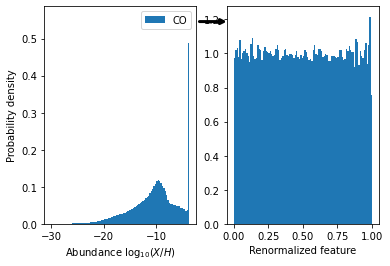

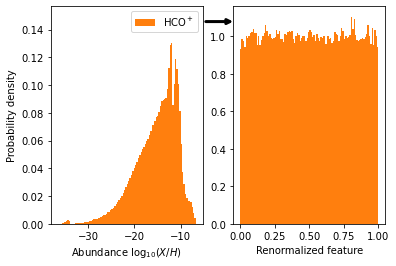

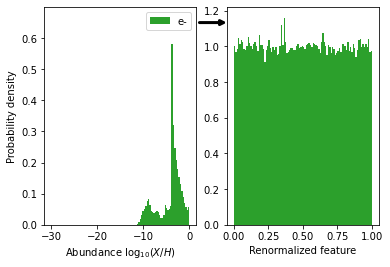

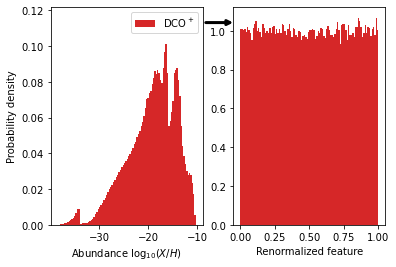

In [11]:
from matplotlib.patches import ConnectionPatch

if TRANSFORMER is not None:
    y_trans = sklearn.base.clone(TRANSFORMER).fit_transform(y)

    for i, feature in enumerate(y.columns):
        fig, ax = plt.subplots(1, 2)
        values, _, _ = ax[0].hist(
            y[feature], color=COLORS_DICT[feature.rstrip("_norm")],
            label=from_string(feature.strip("_norm")), density=True, bins=100)
        ax[0].set_xlabel("Abundance $\log_{10}(X/H)$")
        ax[0].legend()
        ax[0].set_ylim((0, 1.2 * values.max()))
        ax[0].set_ylabel("Probability density")
        values, _, _ = ax[1].hist(
            y_trans[:, i], color=COLORS_DICT[feature.rstrip("_norm")],
            label=from_string(feature.rstrip("_norm")), density=True, bins=100)
        ax[1].set_xlabel("Renormalized feature")

        con = ConnectionPatch(
            xyA=(1.02, 0.93), xyB=(0, 0.93), coordsA='axes fraction', coordsB='axes fraction',
            axesA=ax[0], axesB=ax[1], color="k", lw=3,
            arrowstyle='-|>'
        )
        fig.add_artist(con)

        plt.savefig(folder / f"{feature}_hist.pdf")
        plt.savefig(folder / f"{feature}_hist.png")


In [12]:
cv = GroupKFold(n_splits=10)

grid = GridSearchCV(
    pipeline,
    grid_dict,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=100
)

### Looking again at the data set

In [13]:
X

,log(numberdens),log(temperature),log(ionization)
0,10.491362,2.444046,-8.263611
1,10.465383,2.449785,-8.235246
2,10.392697,2.466241,-8.170940
3,10.276462,2.491369,-8.073630
4,10.127105,2.522403,-7.951854
...,...,...,...
1183207,4.285557,1.137237,-14.509422
1183208,4.222716,1.152760,-14.451123
1183209,4.161368,1.168118,-14.376998
1183210,4.100371,1.183253,-14.284635


In [14]:
y

,CO_norm,HCO+_norm,e-_norm,DCO+_norm
0,-8.839115,-12.937479,-3.551344,-17.041113
1,-8.981083,-13.120991,-3.526863,-17.240074
2,-9.379860,-13.646063,-3.463789,-17.810634
3,-9.968966,-14.414927,-3.363709,-18.646034
4,-10.634344,-15.277685,-3.236684,-19.588029
...,...,...,...,...
1183207,-7.711526,-11.658191,-4.252134,-16.293888
1183208,-7.953204,-11.855361,-4.143535,-16.532520
1183209,-8.221350,-12.075008,-4.034263,-16.782970
1183210,-8.513783,-12.310085,-3.918527,-17.032185


In [15]:
groups = df_all["Disk ID"]
groups

0            1
1            1
2            1
3            1
4            1
          ... 
1183207    540
1183208    540
1183209    540
1183210    540
1183211    540
Name: Disk ID, Length: 1183212, dtype: int64

Split training and testing set

In [16]:
train_indx, test_indx = next(
    GroupKFold().split(X, y, groups)
)
X_train, X_test, y_train, y_test = X.loc[train_indx], X.loc[test_indx], y.loc[train_indx], y.loc[test_indx]
# only use first 5 species for cross-valifation, takes ages othervise
y_cv = y_train.iloc[:,:5]
groups_train = groups.loc[train_indx]

### Run fitting

First, for the best estimator

In [17]:
grid.fit(X_train, y_train, groups=groups_train)

Fitting 10 folds for each of 34 candidates, totalling 340 fits


GridSearchCV(cv=GroupKFold(n_splits=10),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('quantiletransformer',
                                                                             QuantileTransformer(n_quantiles=100)),
                                                                            ('kneighborsregressor',
                                                                             KNeighborsRegressor())]),
                                                  transformer=QuantileTransformer(n_quantiles=100)),
             n_jobs=-1,
             param_grid={'regressor__kneighborsregressor__n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        15,  16,  18,  20,  22,  24,  26,  29,  32,  35,  39,  42,  47,
        51,  56,  62,  68,  75,  82,  91, 100])},
             scoring='neg_mean_squared_error', verbose=100)

In [18]:
grid.best_params_, grid.best_score_, grid.best_estimator_

({'regressor__kneighborsregressor__n_neighbors': 18},
 -0.4479729098036215,
 TransformedTargetRegressor(regressor=Pipeline(steps=[('quantiletransformer',
                                                       QuantileTransformer(n_quantiles=100)),
                                                      ('kneighborsregressor',
                                                       KNeighborsRegressor(n_neighbors=18))]),
                            transformer=QuantileTransformer(n_quantiles=100)))

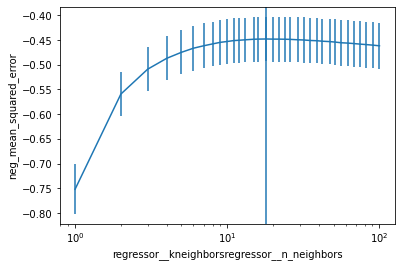

In [19]:
fig, ax = plt.subplots(1, 1)
converged = np.isfinite(grid.cv_results_["mean_test_score"])
ax.errorbar(
    np.array([list(dictionary.values())[0] for dictionary in grid.cv_results_["params"]])[converged],
    grid.cv_results_["mean_test_score"][converged],
    yerr=grid.cv_results_["std_test_score"][converged])
ax.semilogx()
ax.axvline(list(grid.best_params_.values())[0])
ax.set_xlabel(list(grid.best_params_.keys())[0])
ax.set_ylabel(grid.scoring)
plt.savefig(folder / "best_estimation.pdf")
plt.savefig(folder / "best_estimation.png")

Second, the best estimator on the whole training set

In [20]:
grid.best_estimator_.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('quantiletransformer',
                                                      QuantileTransformer(n_quantiles=100)),
                                                     ('kneighborsregressor',
                                                      KNeighborsRegressor(n_neighbors=18))]),
                           transformer=QuantileTransformer(n_quantiles=100))

### Save the results

In [21]:
with open(folder / "properties.ini", "a") as fff:
    print(grid.best_params_, file=fff)
    print(grid.cv_results_, file=fff)


In [22]:
with open(folder / "model.pkl", "wb") as fff:
    obj_to_save = grid.best_estimator_
    obj_to_save.X = PARAMETERS
    obj_to_save.y = SPECIES_TO_FIT
    print(obj_to_save.X)
    print(obj_to_save.y)
    pickle.dump(obj_to_save, fff)

('log(numberdens)', 'log(temperature)', 'log(ionization)')
('CO', 'HCO+', 'e-', 'DCO+')


### Analyze performance of fitting
#### Helper functions

In [23]:
class LogNormMaxOrders(colors.LogNorm):
    """`matplotlib.colors.LogNorm` subclass with maximal range"""

    def __init__(self, vmin=None, vmax=None, clip=False, maxdepth: float = 1e6):
        self.maxdepth = maxdepth
        super().__init__(vmin, vmax, clip)

    def autoscale_None(self, A):
        super().autoscale_None(A)
        self.vmin = max([self.vmin, self.vmax / self.maxdepth])


def visualize_3d_spice_and_model(
        df_3d_visualize: pd.DataFrame,
        spice="CO",
        x_label: str = "log(temperature)",
        y_label: str = "log(numberdens)",
):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    color = COLORS_DICT.get(spice, None)
    ax.scatter(
        df_3d_visualize[x_label],
        df_3d_visualize[y_label],
        df_3d_visualize[with_norm(spice)],
        alpha=1,
        color='black',
        s=0.1
    )
    ax.plot_trisurf(
        df_3d_visualize[x_label],
        df_3d_visualize[y_label],
        df_3d_visualize[with_predicted(spice)],
        color=color
    )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(spice)
    return fig


def visualize_2d_residual(
        df: pd.DataFrame,
        spice="CO",
        x_label: str = "log(temperature)",
        y_label: str = "log(numberdens)",
        norm=colors.Normalize(vmin=-2, vmax=2),
        norm_disp=colors.Normalize(vmin=0, vmax=2),
        norm_pred=None,
        gridsize=30,
        xlim=None,
        ylim=None,
        cmap=None,
        panels=(0, 1, 2, 3),
        do_hist=True,
):
    label_dict = {
        "log(temperature)": r"$\log T, K$",
        "log(numberdens)": r"$\log n,\ \mathrm{cm}^{-3}$",
        "log(uv)": r"$\log F_{UV},\ \mathrm{Draine}$",
        "log(ionization)": r"$\log \zeta_{X+CR},\ \mathrm{s}^{-1}$"
    }
    if norm_pred is None:
        max_pred = math.floor(df[with_norm(spice)].max())
        norm_pred = matplotlib.colors.Normalize(
            vmax=max_pred, vmin=max_pred - 5
        )
    if cmap is None:
        cmap = COLORMAPS_DICT.get(spice, None)
    df.loc[:, with_diff(spice)] = df.loc[:, with_norm(spice)] - df.loc[:, with_predicted(spice)]
    fig, axes = plt.subplots(
        1, len(panels), sharex=False, sharey=True, figsize=(3 * len(panels) + 1, 4),
        gridspec_kw = dict(wspace=0.1)
    )

    if 0 in panels:
        df.plot.hexbin(x_label, y_label, with_predicted(spice),
                       gridsize=gridsize, ax=axes[panels.index(0)],
                       cmap=cmap,
                       grid=True, norm=norm_pred,
                       colorbar=False
                       )
        cbar = fig.colorbar(
            axes[panels.index(0)].collections[0],
            ax=axes[panels.index(0)], location='top',
            pad=0
        )
        # plt.setp(cbar.ax.get_xticklabels()[0], visible=False)
    if 1 in panels:
        df.plot.hexbin(x_label, y_label, with_diff(spice),
                       gridsize=gridsize, ax=axes[panels.index(1)],
                       cmap="coolwarm", norm=norm,
                       grid=True,
                       colorbar=False)
        cbar = fig.colorbar(
            axes[panels.index(1)].collections[0],
            ax=axes[panels.index(1)], location='top',
            pad=0
        )
        plt.setp(cbar.ax.get_xticklabels()[0], visible=False)
    if 2 in panels:
        df.plot.hexbin(x_label, y_label, with_diff(spice),
                       gridsize=gridsize, ax=axes[panels.index(2)],
                       cmap="viridis", norm=norm_disp,
                       reduce_C_function=np.std,
                       grid=True,
                       colorbar=False)
        cbar = fig.colorbar(
            axes[panels.index(2)].collections[0],
            ax=axes[panels.index(2)], location='top',
            pad=0
        )
        plt.setp(cbar.ax.get_xticklabels()[0], visible=False)

    hist_norm = colors.LogNorm(vmax=1e-1, vmin=1e-6)
    total_spice = df[spice].sum()
    df[f"{spice} (rel)"] = df[spice] / total_spice

    if 3 in panels:
        axes[panels.index(3)].set_xlim(axes[0].get_xlim())
        ax_hist = axes[panels.index(3)]

    else:
        fig_hist, ax_hist = plt.subplots()

    df.plot.hexbin(
        x_label, y_label,
        f"{spice} (rel)", gridsize=30, reduce_C_function=np.sum, ax=ax_hist,
        norm=hist_norm,
        cmap=COLORMAPS_DICT.get(spice, None),
        grid=True,
       colorbar=False
    )
    cbar = fig.colorbar(
            ax_hist.collections[0],
            ax=ax_hist, location='top',
            pad=0
        )
    plt.setp(cbar.ax.get_xticklabels()[:2], visible=False)
    x, y, c = *ax_hist.collections[-1].get_offsets().T, ax_hist.collections[-1].get_array()

    for ax in axes:
        ax.set_xlabel(label_dict[x_label])
        ax.set_ylabel(label_dict[y_label])

    patch = patches.Patch(color=COLORS_DICT.get(spice, "w"), label=from_string(spice))
    axes[0].legend(handles=[patch], loc='upper left')

    for ax in axes:
        # ax.contour(hist_x, hist_y, hist_z.T, colors='black', alpha=0.25)
        if do_hist:
            ax.tricontour(x, y, c, levels=np.geomspace(hist_norm.vmin, hist_norm.vmax, 9), colors="k", alpha=0.25)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    return fig


def plot_ratio(
        df: pd.DataFrame,
        sp1: str, sp2: str,
        norm: matplotlib.colors.Normalize = matplotlib.colors.Normalize(-7, -1),
        min_abundance: float = -20,
):
    try:
        sp_ratio = f"{sp1}/{sp2}"
        indices = (df[with_norm(sp1)] > min_abundance) & (df[with_norm(sp2)] > min_abundance)
        df[with_norm(sp_ratio)] = df[with_norm(sp1)] - df[with_norm(sp2)]
        df[with_predicted(sp_ratio)] = df[with_predicted(sp1)] - df[with_predicted(sp2)]
        df[sp_ratio] = df[sp1] / df[sp2]
        fig = visualize_2d_residual(df.loc[indices], spice=sp_ratio, norm_pred=norm,
                                    cmap="coolwarm", panels=(0,1,2), do_hist=False)
        fig.savefig(folder / f"{sp_ratio.replace('/', '_')}.pdf")
        fig.savefig(folder / f"{sp_ratio.replace('/', '_')}.png")
    except KeyError as e:
        print("Species not found! ", e)

Compare predicted values on a testing set

In [24]:
predicted = grid.best_estimator_.predict(X_test).T

In [25]:
df_test = df_all.loc[test_indx]
for i, spice in enumerate(SPECIES_TO_FIT):
    df_test[with_predicted(spice)] = predicted[i, :]

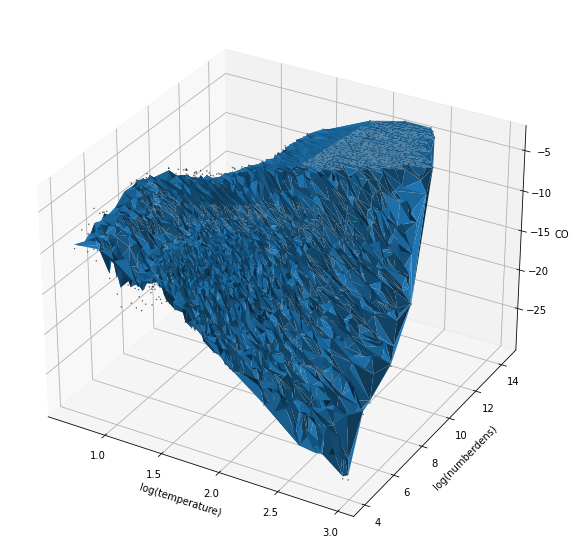

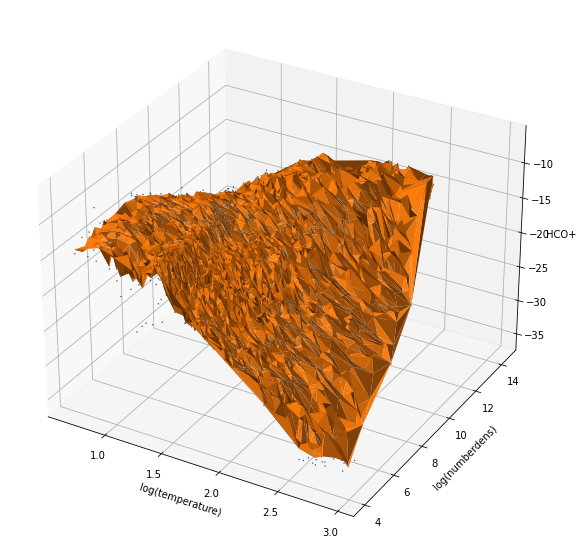

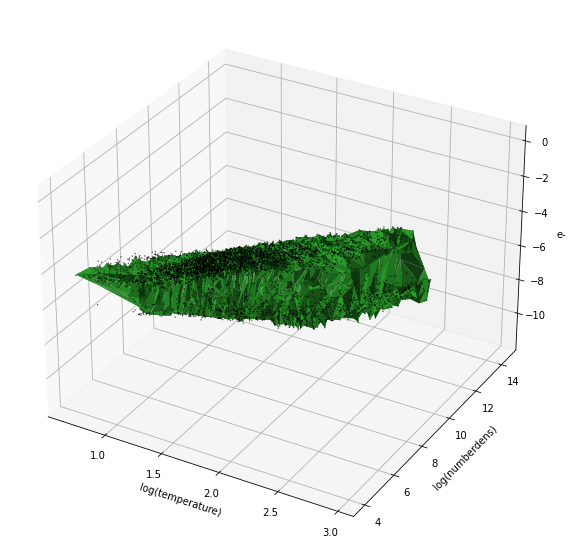

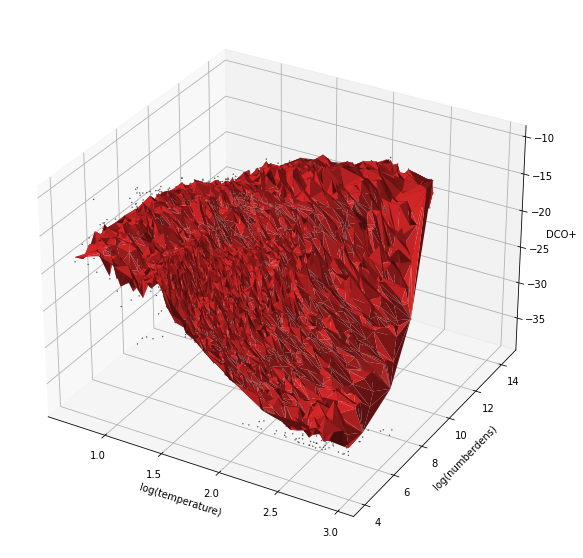

In [26]:
df_3d_visualize = df_test.sample(frac=1 / STEP_3D)
for spice in SPECIES_TO_FIT:
    fig = visualize_3d_spice_and_model(df_3d_visualize, spice=spice)
    plt.savefig(folder / f"{spice}_3d.pdf")
    plt.savefig(folder / f"{spice}_3d.png")
plt.show()

In [27]:
df_test

,Gas Number Density,Gas temperature,Dust temperature,Radius,Height,AV_true,G_UV,AV_from_Gfactor,radiation_strength,IR_Total[1/s],Disk ID,HCO+,DCO+,e-,CO,log(numberdens),log(temperature),log(uv),log(ionization),CO_norm,HCO+_norm,e-_norm,DCO+_norm,CO_pred,HCO+_pred,e-_pred,DCO+_pred
5706,1.080000e+11,355.55460,355.55460,0.17575,0.00000,1.011372,2.263158e+06,1.953970,4.347030e+07,1.689420e-09,4,6.280000e+00,3.770000e-04,1.700000e+07,22400.000000,11.033424,2.550906,6.354715,-8.772262,-6.683176,-10.235464,-3.802975,-14.457082,-5.883132,-9.636423,-4.735230,-13.628170
5707,9.300000e+10,362.65280,362.65280,0.17575,0.00222,0.668068,3.012409e+06,1.661230,5.680158e+07,1.873580e-09,4,3.270000e+00,1.840000e-04,1.570000e+07,5520.000000,10.968483,2.559491,6.478914,-8.727328,-7.226544,-10.453935,-3.772583,-14.703665,-6.335122,-9.918583,-4.212417,-13.997686
5708,6.560000e+10,383.37220,383.37220,0.17575,0.00445,0.397645,7.322286e+06,0.813205,1.394668e+08,2.577510e-09,4,5.470000e-01,2.710000e-05,1.220000e+07,754.000000,10.816904,2.583621,6.864647,-8.588800,-7.939532,-11.078917,-3.730544,-15.383935,-7.292528,-10.644901,-3.765255,-14.599911
5709,4.050000e+10,416.03420,416.03420,0.17575,0.00667,0.216676,3.269042e+07,0.004747,3.811598e+08,4.224880e-09,4,2.210000e-02,9.320000e-07,9.590000e+06,57.100000,10.607455,2.619129,7.514421,-8.374186,-8.850819,-12.263063,-3.625636,-16.638039,-8.348309,-11.631850,-3.703554,-15.766472
5710,2.230000e+10,457.99290,457.99290,0.17575,0.00890,0.109549,8.646934e+07,-0.426831,6.723166e+08,7.308460e-09,4,1.260000e-04,4.320000e-09,9.270000e+06,1.100000,10.348305,2.660859,7.936862,-8.136174,-10.306912,-14.247934,-3.381225,-18.712821,-9.355054,-12.503933,-3.521268,-17.162653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181318,1.910000e+04,11.97952,11.97952,471.48664,101.45915,0.001385,5.786322e-01,4.123260,2.022696e+00,2.750390e-15,539,4.580000e-08,1.120000e-12,9.420000e-01,0.000618,4.281033,1.078439,-0.237597,-14.560606,-7.490045,-11.620168,-4.306982,-16.231815,-9.776088,-13.151343,-3.733115,-17.711732
1181319,1.680000e+04,12.40955,12.40955,471.48664,107.42733,0.001221,5.874773e-01,4.001150,2.220215e+00,3.018630e-15,539,2.810000e-08,6.260000e-13,1.020000e+00,0.000345,4.225309,1.093756,-0.231009,-14.520190,-7.687490,-11.776603,-4.216709,-16.428735,-10.010852,-13.288411,-3.722769,-17.846601
1181320,1.480000e+04,12.85345,12.85345,471.48664,113.39552,0.001076,5.982761e-01,3.866850,2.465278e+00,3.378510e-15,539,1.650000e-08,3.420000e-13,1.110000e+00,0.000183,4.170262,1.109020,-0.223098,-14.471275,-7.907811,-11.952778,-4.124939,-16.636236,-10.854701,-14.010886,-3.695928,-18.470792
1181321,1.300000e+04,13.30958,13.30958,471.48664,119.36371,0.000948,6.115192e-01,3.719560,2.771685e+00,3.837450e-15,539,9.410000e-09,1.860000e-13,1.200000e+00,0.000093,4.113943,1.124164,-0.213590,-14.415957,-8.147332,-12.140354,-4.034762,-16.844430,-10.402117,-13.738829,-3.712671,-18.360429


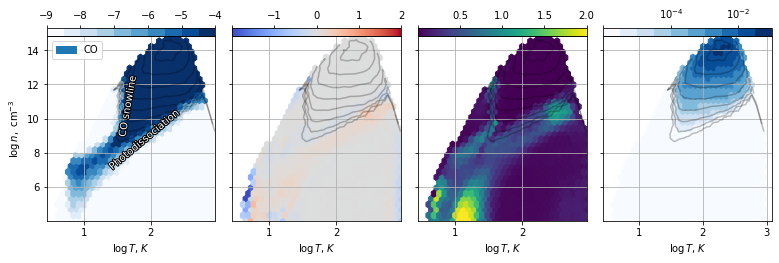

In [28]:
try:
    fig = visualize_2d_residual(df_test, spice="CO")
    # fig.axes[0].text(1.0, 9, "Midplane", rotation=60)
    txt = fig.axes[0].text(1.5, 9, "CO snowline", rotation=80, color='w')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
    # txt = fig.axes[0].text(1.95, 12, "Inner\ndisk", color='white')
    # txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
    # txt = fig.axes[0].text(0.8, 6, "Outer\ndisk", color='w')
    # txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
    txt = fig.axes[0].text(1.35, 7, "Photodissociation", rotation=40, color='w')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
    # fig.axes[0].text(1.5, 6, "Atmosphere", color='black')
    # fig.axes[1].text(1.3, 8, "Little bias\nbelow chemistry\nuncertainty", color='black')
    # txt = fig.axes[2].text(1.15, 4.25, "Underfitting\ndue to importance\nof radiation\nlittle CO anyway", color='w',
    #                        rotation=45)
    # txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
    # txt = fig.axes[2].text(1.15, 8.85, "Good fit at dense and\nCO-rich conditions", color='w', rotation=40)
    # txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='k')])
    # txt = fig.axes[3].text(1.75, 12, "Most of CO\n in data", color='w')
    # txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
    # fig.axes[3].text(1.8, 5, "No CO\nin data", color='black')
    fig.savefig(folder / "explanation.pdf")
except KeyError:
    print("CO is not in SPECIES_TO_FIT")

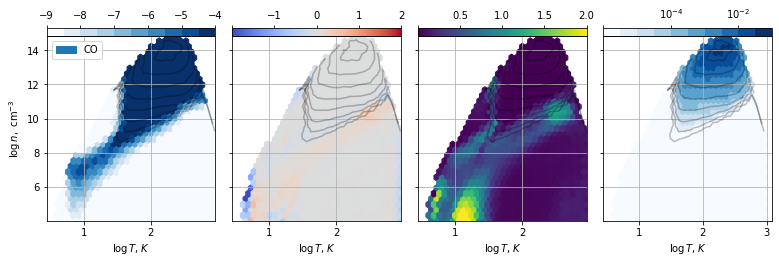

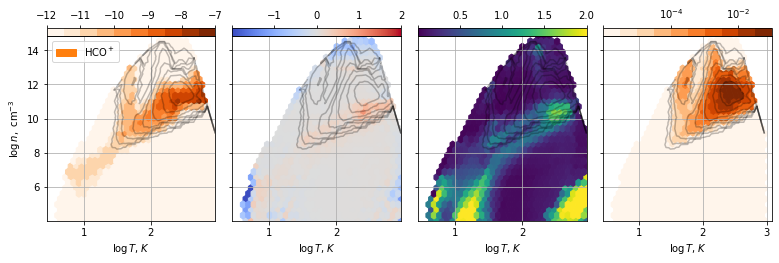

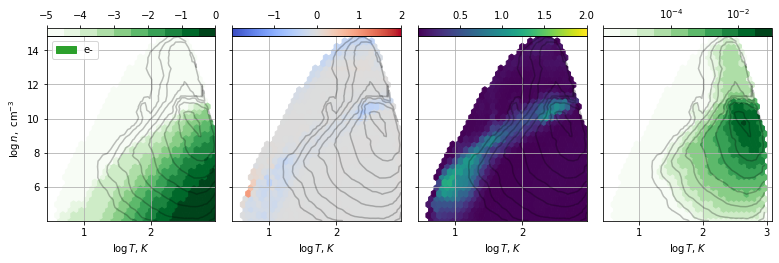

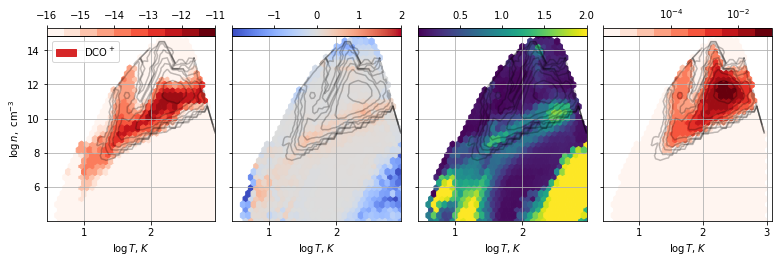

In [29]:
for spice in SPECIES_TO_FIT:
    fig = visualize_2d_residual(df_test, spice=spice)
    plt.savefig(folder / f"{spice}_2d.pdf")
    plt.savefig(folder / f"{spice}_2d.png")
plt.show()

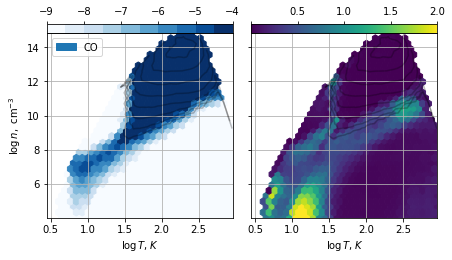

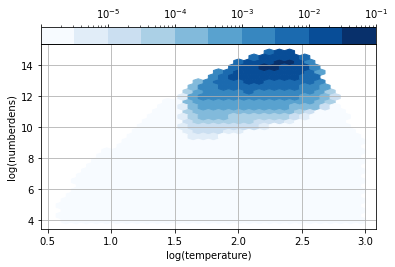

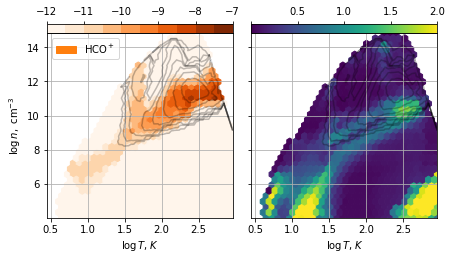

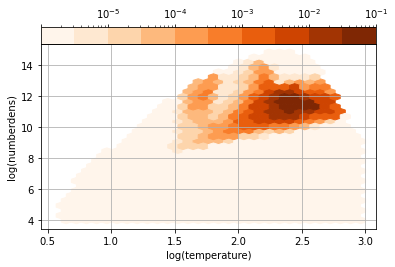

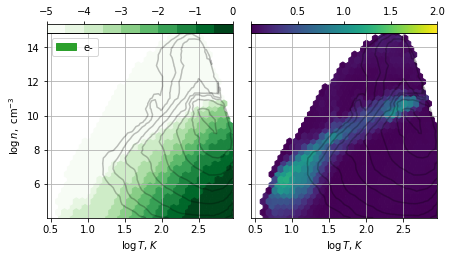

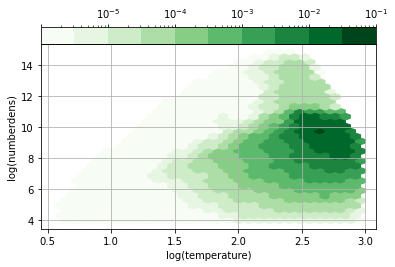

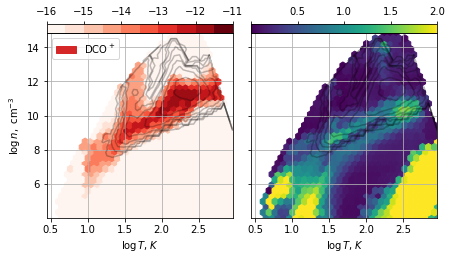

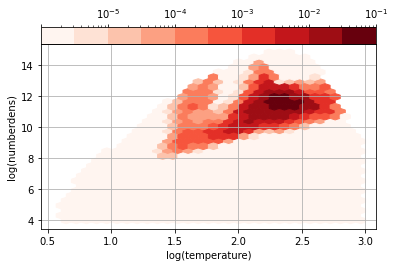

In [30]:
for spice in SPECIES_TO_FIT:
    fig = visualize_2d_residual(df_test, spice=spice, panels=(0,2))
    fig.savefig(folder / f"{spice}_reduced_2d.pdf", bbox_inches="tight")
    fig.savefig(folder / f"{spice}_reduced_2d.png", bbox_inches="tight")

C:\Users\smirn\AppData\Local\Temp\ipykernel_29904\3344648135.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, with_diff(spice)] = df.loc[:, with_norm(spice)] - df.loc[:, with_predicted(spice)]
C:\Users\smirn\AppData\Local\Temp\ipykernel_29904\3344648135.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{spice} (rel)"] = df[spice] / total_spice


Species not found!  'HDO_norm'
Species not found!  'HDCO_norm'
Species not found!  'N2D+_norm'
Species not found!  'HCN_norm'


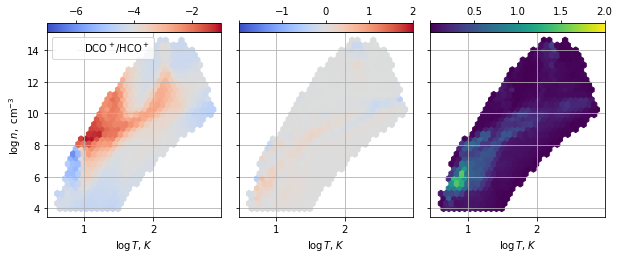

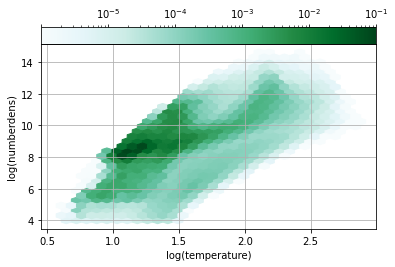

In [31]:
for ratio in [
    ["DCO+", "HCO+", matplotlib.colors.Normalize(-7, -1)],
    ["HDO", "H2O", matplotlib.colors.Normalize(-7, -1)],
    ["HDCO", "H2CO", matplotlib.colors.Normalize(-7, -1)],
    ["N2D+", "N2H+", matplotlib.colors.Normalize(-7, -1)],
    ["HCN", "HNC", matplotlib.colors.Normalize(-2.5, 2.5)]
]:
    plot_ratio(df_test, *ratio)